## Feature selection: numerical

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel

import os

#os.environ["PATH"] += os.pathsep + 'C:\\Users\\jander33\\Desktop\\project_5\\programs\\graphviz\\bin'


import sys
sys.path.append('../code/quickpipeline')
sys.path.append('../code/cleaners')
sys.path.append('../code/features')
#sys.path.append(r'C:\\Users\\jander33\\Desktop\\project_5\\programs')
#sys.path.append(r'C:\Miniconda3\envs\tf\Lib\site-packages')
#print(sys.path)

from quickpipeline import QuickPipeline
from J_cleaner import *
from j_features import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/User

In [2]:
df = pd.read_csv('../data/processed2/class_dfs/WR_27_num.csv')
df.drop(['Unnamed: 0', 'X'], axis = 1, inplace = True)

In [3]:
data = pd.read_csv('../data/processed2/WR_27_p2.csv')
data.drop(['Unnamed: 0', 'X'], axis = 1, inplace = True)

In [4]:
#df.head()
y =  data[['TRV.Win']]
y1 = data[['TRV.Win', 'Competitor.Premium']]

#y['TRV.Win'].value_counts()

### Outliers -> Isolation forest

In [5]:
number_df = sub_df(df)

In [6]:
number_df.head(2)
#number_df.columns

,TRV.Price,nbr_comp,count,rrv_rt_fct,tot_bld_annl_rev_amt,fnl_prc_pt_fct,tot_ref_rule_cnt,agt_subm_pol_cnt,terr_pctl_bldgcrime,terr_pctl_bldgfire,terr_pctl_weather,terr_pctl_water,terr_pctl_cntscrime,terr_pctl_cntsfire,terr_pctl_liab,afi_pol_cnt,pri_clm_cnt,prcnt_blg_tiv,prcnt_pol_cmp
0,3985,1,1,0.72,450000.0,1.0000,0,1,77,16,98,48,30,46,96,1,0,0.0,1.0
1,6813,4,1,1.00,100000.0,0.7286,1,1,94,96,2,88,91,73,78,0,0,1.0,1.0


In [7]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=.05)
clf.fit(number_df)
outliers = clf.predict(number_df)

outliers = pd.DataFrame(outliers)
outliers.rename(columns={0: 'outliers'}, inplace=True)
df2 = pd.concat([number_df, outliers, y], axis=1)


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [8]:
print('previous shape', df2.shape)
print(y['TRV.Win'].value_counts())

nonwin = df2[df2['TRV.Win'] == 0]
win = df2[df2['TRV.Win'] == 1]

out = outliers[outliers['outliers'] == -1]
print('5% of outliers: ', out.shape, ' reduce to ?% of the data eventually')

reduced_nonwin = nonwin[nonwin['outliers'] == 1]
print('non-wins after removal: ', reduced_nonwin.shape)

reduced_win = win[win['outliers'] == 1]

print('wins after removal: ', reduced_win.shape)
print('this is an imbalance improvement of almost 2%.')

previous shape (28105, 21)
0    19790
1     8315
Name: TRV.Win, dtype: int64
5% of outliers:  (1406, 1)  reduce to ?% of the data eventually
non-wins after removal:  (18671, 21)
wins after removal:  (8028, 21)
this is an imbalance improvement of almost 2%.


In [10]:
outliers_response_comp_prem = pd.concat([outliers, y1], axis=1)


In [11]:
outliers_response_comp_prem.to_csv('../data/processed3/outliers_response.csv', index=False)

### Feature selection with XG BOOST

In [12]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree, to_graphviz

In [13]:
pipeline = QuickPipeline(categorical_features=None) 
X = pipeline.fit_transform(df) 
y_ = np.ravel(y)

model = XGBClassifier(max_depth=5,
                      min_child_weight=20,
                      colsample_bytree=0.7,
                      gamma=0.1,
                      reg_alpha=0.1,
                      reg_lambda=0.1,
                      max_delta_step=1)
model.fit(X, y_)


scores = cross_val_score(model, X, y_, cv=5)
print(scores)  


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

[0.76214197 0.75965131 0.76392101 0.75627113 0.75484789]


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
# Print the feature ranking

print("Feature ranking:")

for i in range(0, len(indices)):
    print('{}. Feature: {}  with weight: {}'.format(i + 1, X.columns[indices[i]], importances[indices[i]]))


Feature ranking:
1. Feature: TRV.Price  with weight: 0.18059425055980682
2. Feature: tot_bld_annl_rev_amt  with weight: 0.10584957897663116
3. Feature: fnl_prc_pt_fct  with weight: 0.104456827044487
4. Feature: terr_pctl_weather  with weight: 0.07056638598442078
5. Feature: terr_pctl_liab  with weight: 0.06917363405227661
6. Feature: terr_pctl_cntscrime  with weight: 0.0622098408639431
7. Feature: terr_pctl_bldgfire  with weight: 0.06128133833408356
8. Feature: prcnt_blg_tiv  with weight: 0.05803157016634941
9. Feature: terr_pctl_bldgcrime  with weight: 0.05663881078362465
10. Feature: terr_pctl_water  with weight: 0.04688950628042221


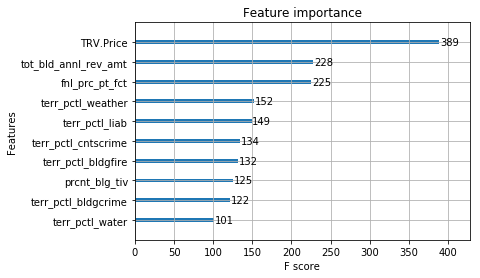

In [15]:
# plot feature importance
plot_importance(model, max_num_features=10)
plt.show()


In [16]:
import pylab
import graphviz 
plot_tree(model, num_trees=0, rankdir='UT', ax=None)


ModuleNotFoundError: No module named 'graphviz'

In [17]:
# manually select features IOT preserve column names
indices = np.argsort(importances)[::-1][:15]
feat_top = X.columns[indices][0:15]
num_df = X[feat_top]

In [18]:
# model_re = SelectFromModel(model, threshold='.5*mean', prefit=True)
# X_re = model_re.transform(X)
# num_df = pd.DataFrame(X_re)
# num_df.shape   

In [19]:

num_df.to_csv('../data/processed3/num_df.csv', index=False)

### Better graph
class_names and balanced seem to cause issues

In [35]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = tree.DecisionTreeClassifier(max_depth=3) #class_weight="balanced")
clf = clf.fit(X, np.ravel(y))


In [36]:
dot_data = tree.export_graphviz(clf, out_file=None,  feature_names=X.columns,  
class_names=None,  filled=True, rounded=True, special_characters=True) 


graph = graphviz.Source(dot_data)  

graph.render('img/dtree_render',view=True)

'img/dtree_render.pdf'